# Semi-conductor dataset
The semi-conductor dataset is a large dataset composed of nearly 600 features for testing semi-conductors. For detailed information consult the README.md

#### Objective and tasks
Our objective is to use the features to predict whether a semi-conductor has passed a validation test. In order to do so we need:
1. To reduces the number of features in the dataset either by dimension reduction techniques or by feature selection or by both. 
2. Predict whether a conductor passed or failed the test
3. Validate our predictions. 
4. Implement a ready to use .py file with the chosen techniques      

#### Plan
"I have a plan, its a crazy plan, but a plan nonetheless" Angus from the Spy-dog animation

Our predictions will be effected essentially by to main decisions: 1. How to reduce the dataset and select the features and 2. What model to use. So our plan might be drawn like this:
1. Clean the data
2. Apply several dimension reduction or feature selection techniques: 
    - PCA and used the components as features
    - Singular Value Decomposition
    - Select the best features via correlations metrics
    - Select features via LASSO Regularization
    - Select features via Random Forest Importance
    
3. Use the end features or components to predict via several models:
    - Logistic regression
    - Random forest
    - Gradient boosting machine
4. From step 4 we will have 12 combinations of reduction techniques and models, we may chose the top 3 or 4 of them and fine tune the model via hyperparameter tunning.
5. Validate the model

Note that there are many dimension reduction techniques and model types out there so my choices here are to some extent arbitrary derived only from my previous experience and current knowledge. So by all means any suggestions to improve this are welcomed.   


### Import libraries and data

In [121]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, matthews_corrcoef, RocCurveDisplay 
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix
import pickle

In [116]:
df = pd.read_csv("uci-secom.csv")

In [3]:
df.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


### Data cleaning

Let us first relabel the target column so that the test fail = 0 and the pass = 1 

In [117]:
df['Pass/Fail'] = df['Pass/Fail'].replace(to_replace=[-1,1], value=[1,0])

Let us look at its distribution too.  

Text(0.5, 0, '0: Fail, 2: Pass')

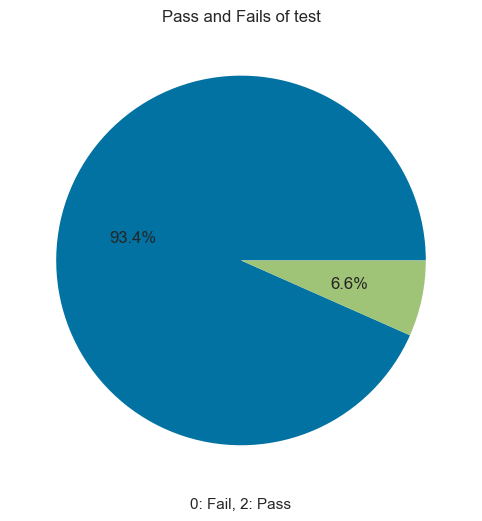

In [5]:
plt.figure(figsize=(10,6))
plt.pie(df['Pass/Fail'].value_counts(),autopct='%1.1f%%')
plt.title("Pass and Fails of test")
plt.xlabel('0: Fail, 2: Pass')

Our dataset is imbalanced so we need to bear this in mind when modeling

##### NaN handling
We were warned in the documentation that there are a lot of NaNs in this dataset, let us have a look 

In [6]:
np.count_nonzero(df.isna().sum())

538

Nearly all the columns have some missing values. 

In [7]:
df.isna().sum().sort_values(ascending=False).head(20)

158    1429
292    1429
293    1429
157    1429
85     1341
492    1341
220    1341
358    1341
517    1018
245    1018
246    1018
518    1018
382    1018
516    1018
109    1018
111    1018
244    1018
110    1018
384    1018
383    1018
dtype: int64

We see that there are columns with more NaNs than values, which won't help us in the prediction task, so let us remove all columns where there are more then 40% missing values 

In [8]:
def percentna(dataframe, threshold):
    '''Get a list of column names where the number of NaNs is above a % threshold'''
    columns = dataframe.columns[(dataframe.isna().sum()/dataframe.shape[1])>threshold]
    return columns.tolist()

In [9]:
na_columns = percentna(df, 0.4)

In [10]:
len(na_columns)

52

There are 52 features where the number of NaNs is above teh threshold, which is less then 10% of all the features, so let us remove these.

In [11]:
df = df.drop(na_columns, axis = 1)

In [12]:
len(df.columns)

540

There is the timestamp column, which does not really give us any value in terms of prediction, so let us drop it as well.

In [13]:
df = df.drop('Time', axis=1)

##### Outliers
Before imputing the missing values in the rest of the columns it is a good idea to check for outliers, because when imputing we rely on the existing data points and an outlier can potentially compromise the imputation. So let us apply the common rule of thumb which is that a data point, which is 3*SD away from the mean is considered an outlier.  

The awkward moment here is that there are to much features for us to manually visualize them or checkout their descriptive statistics one by one. Let us start by exploring the number of outliers for each feature.  

In [14]:
def outlier_explorer(df, columns, n_std):
    '''Explore the number of outliers for each column'''
    outlier_df = pd.DataFrame({'Name':[],
                               'Outliers':[],
                               'NaNs':[]})

    for column in columns:
        mean = df[column].mean()
        sd = df[column].std()
        n_outleirs = sum((df[column] > mean+(n_std*sd)))
        n_nan = df[column].isna().sum()
        outlier_df.loc[len(outlier_df)] = [column, n_outleirs, n_nan]

    return outlier_df

In [15]:
x = outlier_explorer(df, df.columns, 3)
x.sort_values(by = 'Outliers', ascending=False)


,Name,Outliers,NaNs
528,576,70,0
526,574,68,0
38,38,64,1
529,577,62,0
525,573,60,0
...,...,...,...
421,444,0,1
184,193,0,4
183,192,0,4
424,447,0,1


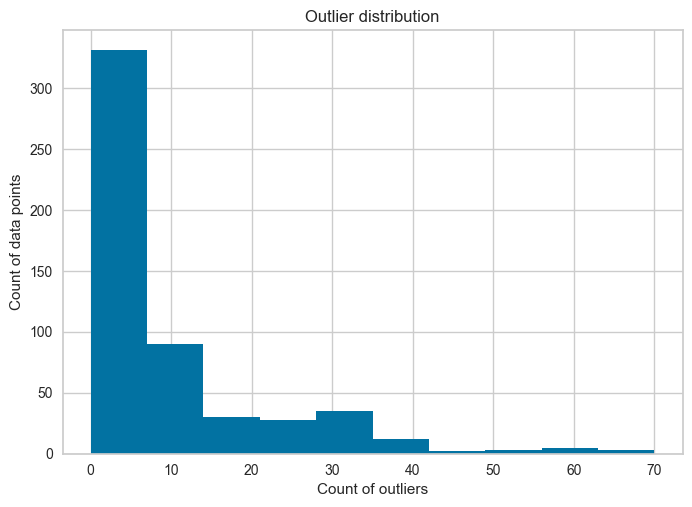

In [16]:
plt.hist(x['Outliers'])
plt.title('Outlier distribution')
plt.xlabel('Count of outliers')
plt.ylabel('Count of data points')
plt.show()

In [17]:
len(x[x['Outliers'] > 40])

13

Most have 0 to 5 outliers, while a very small portion of the features (13 to be exact) have over 40 outliers. These are suspicious and show an obvious visual separation from the other features. Let us look at them more closely.    

In [18]:
z = x[x['Outliers'] > 40]
df[(z['Name'])].describe()

,38,139,160,274,295,558,572,573,574,575,576,577,589
count,1566.000000,1553.000000,1565.000000,1553.000000,1565.000000,1566.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1566.000000
mean,86.836577,416.766964,555.346326,136.292426,252.999118,0.995009,28.450165,0.345636,9.162315,0.104729,5.563747,16.642363,99.670066
std,0.446756,263.300614,574.808588,85.607784,283.530702,0.083860,86.304681,0.248478,26.920150,0.067791,16.921369,12.485267,93.891919
min,84.732700,0.000000,0.000000,0.000000,0.000000,0.891900,3.540000,0.066700,1.039500,0.023000,0.663600,4.582000,0.000000
25%,86.578300,243.786000,295.000000,81.215600,130.220300,0.955200,7.500000,0.242250,2.567850,0.075100,1.408450,11.501550,44.368600
50%,86.820700,339.561000,438.000000,110.601400,195.825600,0.972700,8.650000,0.293400,2.975800,0.089500,1.624500,13.817900,71.900500
75%,87.002400,502.205900,625.000000,162.038200,273.952600,1.000800,10.130000,0.366900,3.492500,0.112150,1.902000,17.080900,114.749700
max,88.418800,1770.690900,4170.000000,659.169600,2005.874400,1.512100,454.560000,2.196700,170.020400,0.550200,90.423500,96.960100,737.304800


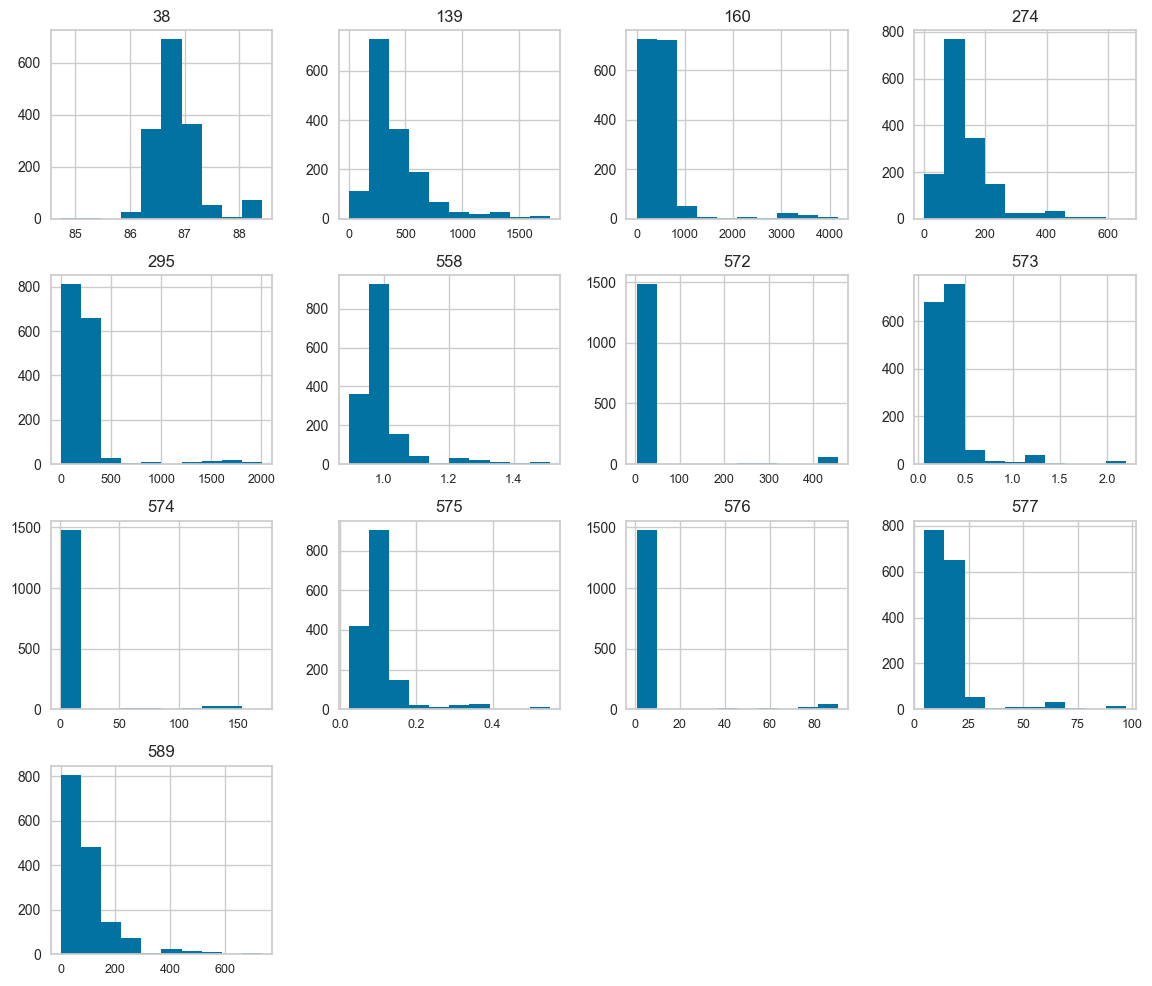

In [19]:
histograms = df[(z['Name'])].hist(figsize=(14,12), xlabelsize = 9)

Looking at these plots visually "I do not like" `160`, `295`, `572`, `573`, `574`, `575`, `576`, `577`, in fact 6 of these fall in to sequence and it is quite possible that they are connected. In a dataset with fewer features I would not remove such only because of their distribution graph, but here we have no context for each feature, we do not know what feature `160` is or how is it measured. Since here our objective is to reduce the dimensionality of the dataset first we may comfortably remove some of these.   

In [20]:
df = df.drop(['160', '295', '572', '573', '574', '575', '576', '577'], axis=1)

I also want to check the relation between number of outliers and number of NaNs (which we still have not imputed). There might be a feature with both a high number of NaNs and outliers. In fact let us sum up the two columns to make a `Bad data point` column

In [21]:
x['Bad data point'] = x['NaNs'] + x['Outliers']
n = x.sort_values(by = 'Bad data point', ascending=False)
n.head(20)

,Name,Outliers,NaNs,Bad data point
472,496,39,51,90
343,362,25,51,76
214,224,25,51,76
528,576,70,0,70
215,225,18,51,69
526,574,68,0,68
473,497,16,51,67
344,363,15,51,66
38,38,64,1,65
260,274,51,14,65


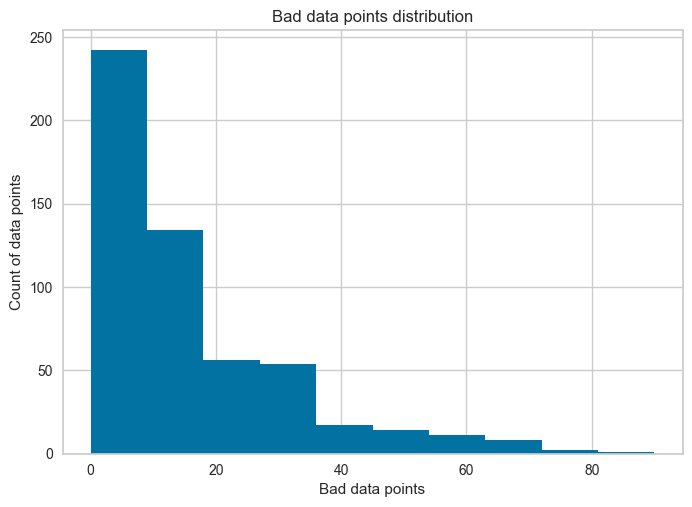

In [22]:
plt.hist(x['Bad data point'])
plt.title('Bad data points distribution')
plt.xlabel('Bad data points')
plt.ylabel('Count of data points')
plt.show()

In [23]:
len(df)

1567

Sixteen features have >= 60 Bad data points. We already removed 5 of these features in the last step. Currently our dataset has 1567 observations so for such features about 3.8% of the data is either Nan or an outlier. That is ok as a whole, just out of curiosity let us explore there 11 features further.  

In [24]:
g = x[~x['Name'].isin(['160', '295', '572', '573', '574', '575', '576', '577'])]
h = g[g['Bad data point'] >= 60]
df[(h['Name'])].describe()

,38,90,139,224,225,274,362,363,483,496,497
count,1566.000000,1516.000000,1553.000000,1516.000000,1516.000000,1553.000000,1516.000000,1516.000000,1543.000000,1516.000000,1516.000000
mean,86.836577,8827.536865,416.766964,0.059370,1041.056588,136.292426,0.018383,333.319601,206.564196,29.865896,11.821030
std,0.446756,396.313662,263.300614,0.071211,433.170076,85.607784,0.021644,138.801928,192.864413,24.621586,4.956647
min,84.732700,7397.310000,0.000000,0.009300,168.799800,0.000000,0.002800,60.988200,0.000000,4.813500,1.949600
25%,86.578300,8564.689975,243.786000,0.029775,718.725350,81.215600,0.009500,228.682525,81.316150,16.342300,8.150350
50%,86.820700,8825.435100,339.561000,0.039800,967.299800,110.601400,0.012500,309.831650,148.317500,22.039100,10.906550
75%,87.002400,9065.432400,502.205900,0.061300,1261.299800,162.038200,0.018600,412.329775,262.865250,32.438475,14.469050
max,88.418800,10746.600000,1770.690900,1.436100,3601.299800,659.169600,0.416300,1072.203100,989.473700,219.643600,40.281800


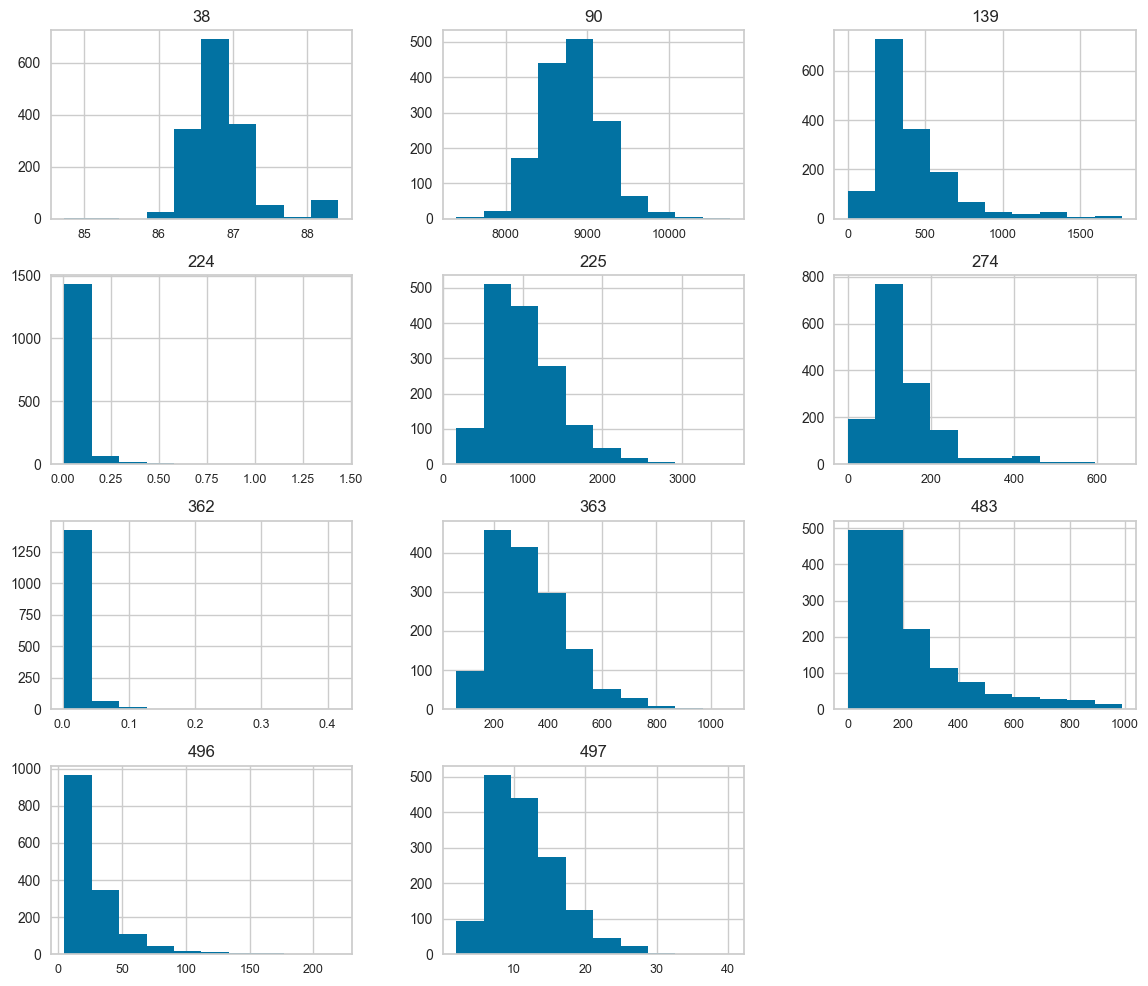

In [25]:
histograms = df[(h['Name'])].hist(figsize=(14,12), xlabelsize = 9)

I believe that the imputation of NaNs and Outliers should suffice for these 11, no need to remove the whole features

#### Train/Test split and impute Outliers and NaNs
Now that we have removed unnecessary features we are left with the imputation of the outliers and NaNs. Notice that we defined the outlier based on the whole dataset, which is better then doing is separately on the train and test dataset. However the imputation of these values should be done separately for the train and test datasets in order to avoid data leakage from one to the other.

The steps I will apply are as followed:
1. Impute outliers with the mean separately for the train and test datasets
2. Fit and apply a `KNNImputer` separately for the train and test datasets 

This way the transformations are independent for the two datasets.

In [26]:
X = df.drop('Pass/Fail', axis=1)
y = df['Pass/Fail']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=67, stratify=y)

In [28]:
def outlier_imputer(df_whole, df_impute, columns, n_std):
    '''Impute outliers with the mean for all columns in a dataset, which keeping NaN values'''
    for column in columns:
        '''Mean and SD are defined by the whole dataset'''
        mean = df_whole[column].mean()
        sd = df_whole[column].std()
    
        '''Outliers are replaced with the mean for the fit dataset train or test respectively'''
        df_impute[column] = np.where(df_impute[column] > mean+(n_std*sd), df_impute[column].mean(), df_impute[column])

    return df_impute

In [29]:
X_train = outlier_imputer(df, X_train, X_train.columns, 3)
X_test = outlier_imputer(df, X_test, X_test.columns, 3)

In [30]:
def nan_imputer(df):
    '''Impute NaNs on the whole dataset using KNNImputer'''
    imputer = KNNImputer()
    imputer.fit(df)

    df = pd.DataFrame(imputer.transform(df), columns=df.columns)

    return df
    

In [31]:
X_train = nan_imputer(X_train)
X_test = nan_imputer(X_test)

In [32]:
np.count_nonzero(X_train.isna().sum())

0

In [33]:
np.count_nonzero(X_test.isna().sum())

0

### Dimension reduction
#### Principle Component Analysis (PCA)  

No let us apply the principle component analysis to the dataset. Since PCA is affected by scale, so you need to scale the features in the data before applying PCA. We can transform the data onto unit scale (`mean = 0` and `SD = 1`), which is a requirement for the optimal performance of many machine learning algorithms. `StandardScaler` helps standardize the data set’s features. You fit on the training set and transform on the training and test set.

In [34]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Let us have a look at the result of the scaling

In [35]:
pd.DataFrame(X_train_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,520,521,522,523,524,525,526,527,528,529
count,1.096000e+03,1.096000e+03,1.096000e+03,1.096000e+03,1.096000e+03,1096.0,1.096000e+03,1.096000e+03,1.096000e+03,1.096000e+03,...,1.096000e+03,1.096000e+03,1.096000e+03,1.096000e+03,1.096000e+03,1.096000e+03,1.096000e+03,1.096000e+03,1.096000e+03,1.096000e+03
mean,-1.461118e-15,3.873625e-15,2.904408e-15,4.149155e-16,4.943329e-17,0.0,2.106993e-17,-1.465170e-15,1.031616e-15,-2.269069e-17,...,-2.100510e-15,1.701802e-16,-2.526932e-14,3.970871e-16,-7.374474e-17,1.588348e-16,-1.709906e-16,2.755298e-16,6.483054e-17,4.051909e-17
std,1.000457e+00,1.000457e+00,1.000457e+00,1.000457e+00,1.000457e+00,0.0,1.000457e+00,1.000457e+00,1.000457e+00,1.000457e+00,...,1.000457e+00,1.000457e+00,1.000457e+00,1.000457e+00,1.000457e+00,1.000457e+00,1.000457e+00,1.000457e+00,1.000457e+00,1.000457e+00
min,-3.852554e+00,-4.435513e+00,-5.075721e+00,-1.841816e+00,-1.607753e+00,0.0,-3.216523e+00,-1.600116e+01,-3.684030e+00,-3.527206e+00,...,-1.230611e+01,-3.995845e+00,-6.508623e+00,-1.693298e+00,-1.937703e+00,-1.700083e+00,-3.406554e+00,-1.717793e+00,-1.707181e+00,-1.380108e+00
25%,-6.698490e-01,-5.350244e-01,-6.418803e-01,-7.795731e-01,-7.842936e-01,0.0,-5.226272e-01,-1.160265e-01,-6.880576e-01,-6.445824e-01,...,1.639582e-02,-4.094657e-01,-6.295162e-01,-6.211496e-01,-6.384421e-01,-6.236447e-01,-6.837585e-01,-7.309473e-01,-7.293652e-01,-6.953624e-01
50%,-4.419508e-02,7.020206e-02,3.187048e-02,-2.020764e-01,-5.170399e-02,0.0,1.013713e-01,4.662888e-02,-1.657971e-03,-2.204388e-02,...,1.159954e-01,6.940094e-02,1.396814e-02,-1.903758e-01,-1.387262e-01,-1.937369e-01,-6.205354e-02,-1.848926e-01,-2.404575e-01,-2.733879e-01
75%,6.222139e-01,5.766971e-01,6.188130e-01,5.546253e-01,4.685914e-01,0.0,5.901495e-01,2.381424e-01,7.382229e-01,6.207948e-01,...,2.311501e-01,6.836620e-01,6.574525e-01,3.361256e-01,3.609897e-01,3.438700e-01,6.141073e-01,5.453733e-01,4.929040e-01,3.182110e-01
max,3.176716e+00,3.182162e+00,2.923831e+00,3.640711e+00,6.249400e+00,0.0,3.134502e+00,7.366023e-01,2.657417e+00,2.982381e+00,...,2.338221e+00,2.326633e+00,2.851149e+00,6.175505e+00,6.157694e+00,6.076335e+00,3.427663e+00,3.282226e+00,3.181896e+00,4.294775e+00


In [36]:
pca_095 = PCA(0.95)
pca_095 = pca_095.fit(X_train_scaled)
pca_095.n_components_

168

We see that when we set the variance explained to be 95% of the datasets initial variance we see that the 530 features are compressed in 169 components, which means that we have reduced the dimensionality about 3 times. But are all these components meaningful? Lets look at the variance explained per feature.  

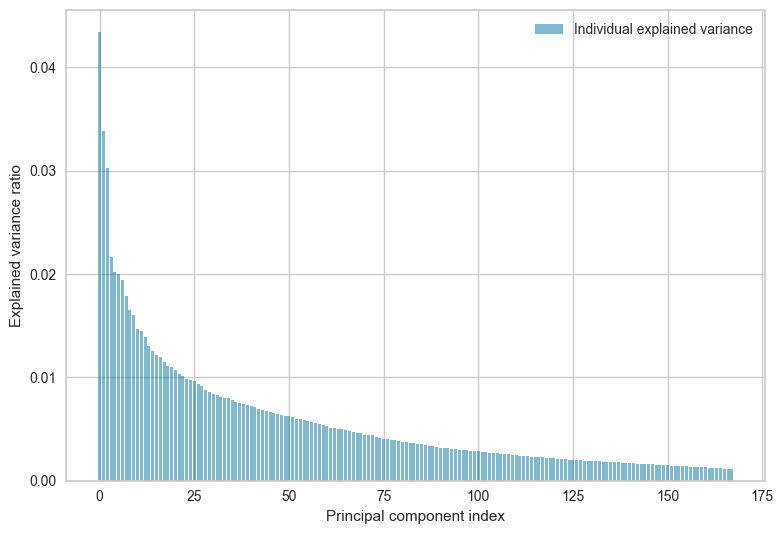

In [37]:
exp_var_pca = pca_095.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

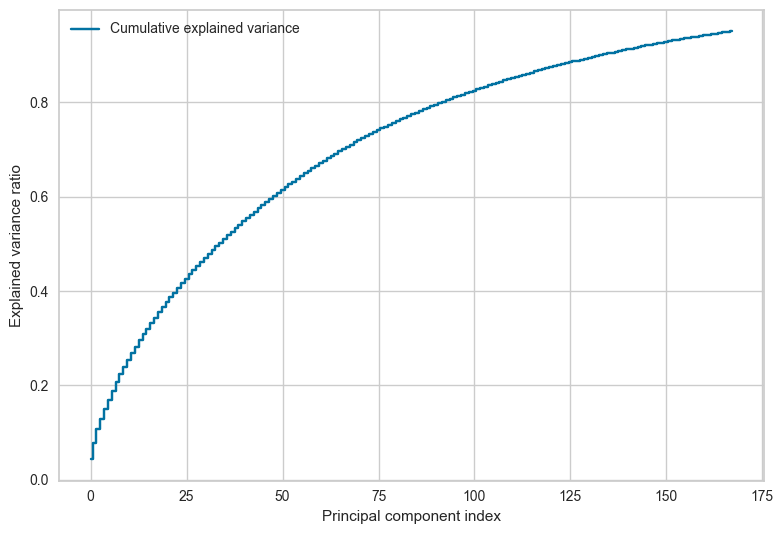

In [38]:
exp_var_pca = pca_095.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We see from the two graphs that even though the first 3 components are strong predictors (they explain more variance the the succeeding), as percentages this is between 4 and 2%, which is not much. The components gradually decrees in explainability, which is to be expected, but there is no visually distinguishable threshold, after which we may disregard some of the components.       

So lets `fit_transform` the dataset using the 95% PCA

In [39]:
X_train_pca_095 = pca_095.fit_transform(X_train_scaled)
X_train_pca_095 = principalDF=pd.DataFrame(data=X_train_pca_095)

Just for arbitrary testing let us state that components with variance explained below 0.5% are to be ignored. Visually this coincides with the 75th component. So let us apply the `PCA(n_components = 75) ` and save it separately.

In [40]:
pca75 = PCA(n_components=75)
X_train_pca_75 = pca75.fit_transform(X_train_scaled)
X_train_pca_75 = principalDF=pd.DataFrame(data=X_train_pca_75)

##### Modeling PCA data
Now let us get to the gist of things, which is to model the dimensionally reduced data. As mentioned we will try three classifiers (LogReg, RF and GBM) and as estimator we need a metric that works well on an imbalanced dataset as we saw earlier. I will use the `balanced_accuracy`.   

In [41]:
seed = 34

pipelines = []
pipelines.append(('ScaledLR', 
                  Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledRF', 
                  Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier(
                      random_state=21))])))
pipelines.append(('ScaledGBM', 
                  Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier(
                      random_state=21))])))

results = []
names = []

for name, model in pipelines:
    start_time = time.time()
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, X_train_pca_095, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(name)
    runtime = time.time() - start_time
    msg = "%s: %f (%f) Run time %f sec" % (name, cv_results.mean(), cv_results.std(), runtime)
    print(msg)


ScaledLR: 0.567362 (0.079092) Run time 0.925195 sec
ScaledRF: 0.499052 (0.001896) Run time 59.558050 sec
ScaledGBM: 0.503858 (0.024755) Run time 212.468349 sec


In [42]:
seed = 34

pipelines = []
pipelines.append(('ScaledLR', 
                  Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledRF', 
                  Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier(
                      random_state=21))])))
pipelines.append(('ScaledGBM', 
                  Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier(
                      random_state=21))])))

results = []
names = []

for name, model in pipelines:
    start_time = time.time()
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, X_train_pca_75, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(name)
    runtime = time.time() - start_time
    msg = "%s: %f (%f) Run time %f sec" % (name, cv_results.mean(), cv_results.std(), runtime)
    print(msg)

ScaledLR: 0.547614 (0.097652) Run time 0.250893 sec
ScaledRF: 0.499048 (0.001905) Run time 32.559028 sec
ScaledGBM: 0.516024 (0.030095) Run time 94.465809 sec


Notice that the reduction of components helped the models, especially the Logistic regression, which withe 75 components practically gave the same f1 as the GBM, which is a big deal. Still the Random forest is the best model out of the three.

#### Singular vector decomposition (SVD)

This method is quite similar to the PCA, it even has similar attributes and parameters. Again let us first scale the dataset.

In [43]:
svd = TruncatedSVD(algorithm='arpack', random_state=23)
svd.fit_transform(X_train_scaled)
svd.explained_variance_ratio_.sum()

0.07722125595555313

Be default the SVD generates 2 components and we see that gives us an explained variance of 7%, which is close to the PCA, remember that the first two components of the PCA had a variance explained ration of 4 and 3.5%. Gradually increasing the `n_components` I decided to stop at 120. 

In [44]:
svd = TruncatedSVD(n_components=120, algorithm='arpack', random_state=23)
svd.fit_transform(X_train_scaled)
svd.explained_variance_ratio_.sum()

0.8719192881009439

Just to keep things simple, let us go ahead and use a svd with 5 components, since it explains more then 95% of the variance

In [45]:
svd = TruncatedSVD(n_components=120, algorithm='arpack', random_state=23)
X_train_svd = svd.fit_transform(X_train_scaled)

##### Modeling the SVD data

In [46]:
seed = 34

pipelines = []
pipelines.append(('ScaledLR', 
                  Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledRF', 
                  Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier(
                      random_state=21))])))
pipelines.append(('ScaledGBM', 
                  Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier(
                      random_state=21))])))

results = []
names = []

for name, model in pipelines:
    start_time = time.time()
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, X_train_svd, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(name)
    runtime = time.time() - start_time
    msg = "%s: %f (%f) Run time %f sec" % (name, cv_results.mean(), cv_results.std(), runtime)
    print(msg)

ScaledLR: 0.557457 (0.057906) Run time 0.318878 sec
ScaledRF: 0.498571 (0.002182) Run time 45.936471 sec
ScaledGBM: 0.508364 (0.026065) Run time 151.720217 sec


The RF has the exact same F1 score with the SVD, which is uncanny. The GBM performed better with the SVD compared to the PCA. 

Just to have a benchmark let us look at the results for the dataset without any prior transformation. 

In [47]:
seed = 34

pipelines = []
pipelines.append(('ScaledLR', 
                  Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledRF', 
                  Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier(
                      random_state=21))])))
pipelines.append(('ScaledGBM', 
                  Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier(
                      random_state=21))])))

results = []
names = []

for name, model in pipelines:
    start_time = time.time()
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(name)
    runtime = time.time() - start_time
    msg = "%s: %f (%f) Run time %f sec" % (name, cv_results.mean(), cv_results.std(), runtime)
    print(msg)

C:\Users\ddash\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ddash\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

ScaledLR: 0.563196 (0.057164) Run time 1.334157 sec
ScaledRF: 0.499510 (0.001471) Run time 55.413913 sec
ScaledGBM: 0.530690 (0.061087) Run time 330.663006 sec


Interestingly enough the Logistic regression gained about 0.03 in the F1 when applying either a PCA or SVD, while the tree based algorithms (RF and GBM) don't care that much in terms of F1 score. However, there is still utility in applying dimension reduction for the RF and GBM, because this reduced the computation time by at least  

### Feature selection 

We used two dimension reduction techniques, which compressed the many features we have into components, which we use for modeling. F1 scores were high and with parameter tuning we can achieve even better results, although the final call will be on the test dataset, which we haven't used yet. However we have a serious drawback here, we don't know, which features work best at predicting a pass or fail.

We could gauge, which component is the best feature in our model, but a component is composed of several features (and not in a straight forward manner). If our goal is to know, which are the best features so we can exclude the rest, the dimension reduction via PCA or SVD are not appropriate. What we need to do is to reduced the dimension directly by selecting only the best features or by features selection.

#### Manual feature selection

The approach here will be to manually apply three principles basically and the approach is inspired by [Matt Namvarpour's Notebook](https://www.kaggle.com/code/halflingwizard/feature-selection-from-600-to-17-features) on the Semi-conductor's dataset. These include:
1. Exclude features with zero or close to zero variance
2. Exclude features with high pairwise correlation
3. Exclude features with a low correlation with our target   

##### Remove low variance features

For the removal of features with low variance we will used the `VarianceThreshold` from `sklearn`

In [48]:
selector = VarianceThreshold()
selector.fit(X_train_scaled)

VarianceThreshold()

In [49]:
mask = selector.get_support()
columns = X_train.columns
selected_cols = columns[mask]
n_features = len(selected_cols)
print(f'remaining features: {n_features}')

remaining features: 414


In [50]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = columns)
X_train_scaled_df = X_train_scaled_df[selected_cols]
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = columns)
X_test_scaled_df = X_test_scaled_df[selected_cols]
X_train_scaled_df.shape

(1096, 414)

##### Remove high pairwise variance

Let us define a helpful function to remove highly correlated features. Here I will be applying a general rule of thumb that correlation of 0.5 between features is undesirable.

In [51]:
def correlation(dataset, threshold):
    '''Get list of pairwise correlated features that surpass a given threshold'''
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [52]:
corr_features = correlation(X_train_scaled_df, 0.5)
X_train_corr = X_train_scaled_df.drop(corr_features, axis=1)
X_test_corr = X_test_scaled_df.drop(corr_features, axis=1)
n_features3 = X_train_corr.shape[1]
print(f'After removing {len(corr_features)} features, there are {n_features3} features left.')

After removing 237 features, there are 177 features left.


#### Remove features that are weakly correlated with the target

In [53]:
def corrwith_target(dataframe, target, threshold):
    '''Get list of features correlated with the target that are below a given threshold'''
    cor = dataframe.corr()
    #Correlation with output variable
    cor_target = abs(cor[target])
    #Selecting non correlated features
    relevant_features = cor_target[cor_target<threshold]
    return relevant_features.index.tolist()[:-1]

In [54]:
# in order to find the correlation with target, I have to add target as a column to X_train_corr
dummy_train = X_train_corr.copy()
dummy_train['target'] = y_train

In [55]:
corrwith_cols = corrwith_target(dummy_train, 'target', 0.05)
X_train_corw = X_train_corr.drop(corrwith_cols, axis=1)
X_test_corw = X_test_corr.drop(corrwith_cols, axis=1)
n_features4 = X_train_corw.shape[1]
print(f'After removing {len(corrwith_cols)} features, there are {n_features4} features left.')

After removing 149 features, there are 28 features left.


Well this is a significant drop from 530 features to 32. Lets see if the remaining 32 features are sufficient for predicting the target.

In [57]:
seed = 34

pipelines = []
pipelines.append(('ScaledLR', 
                  Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledRF', 
                  Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier(
                      random_state=21))])))
pipelines.append(('ScaledGBM', 
                  Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier(
                      random_state=21))])))

results = []
names = []

for name, model in pipelines:
    start_time = time.time()
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, X_train_corw, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(name)
    runtime = time.time() - start_time
    msg = "%s: %f (%f) Run time %f sec" % (name, cv_results.mean(), cv_results.std(), runtime)
    print(msg)

ScaledLR: 0.502835 (0.010244) Run time 0.181191 sec
ScaledRF: 0.500000 (0.000000) Run time 11.932506 sec
ScaledGBM: 0.494121 (0.004787) Run time 20.749014 sec


The 32 features perform quite well, obviously the calculation is very fast and again the RF seems to perform best.    

#### LASSO Regularization feature selection 

Regularization consists of adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model, i.e., to avoid over-fitting. In linear model regularization, the penalty is applied over the coefficients that multiply each predictor. From the different types of regularization, Lasso or L1 has the property that can shrink some of the coefficients to zero. Therefore, that feature can be removed from the model.

In [58]:
logistic = LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=7).fit(X_train, y_train)
model = SelectFromModel(logistic, prefit=True, )

X_train_new = model.fit_transform(X_train)
columns_lasso = model.get_feature_names_out()
X_train_lasso = pd.DataFrame(X_train_new, columns=columns_lasso)


In [59]:
X_train_lasso.shape

(1096, 178)

We see that LASSO reduced the features from 530 to 175. Lets test them out with the three models.

In [60]:
seed = 34

pipelines = []
pipelines.append(('ScaledLR', 
                  Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledRF', 
                  Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier(
                      random_state=21))])))
pipelines.append(('ScaledGBM', 
                  Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier(
                      random_state=21))])))

results = []
names = []

for name, model in pipelines:
    start_time = time.time()
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, X_train_lasso, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(name)
    runtime = time.time() - start_time
    msg = "%s: %f (%f) Run time %f sec" % (name, cv_results.mean(), cv_results.std(), runtime)
    print(msg)

ScaledLR: 0.545580 (0.078545) Run time 0.743197 sec
ScaledRF: 0.500000 (0.000000) Run time 44.035595 sec
ScaledGBM: 0.525732 (0.045913) Run time 180.105208 sec


At this point I should address the elephant in the room. Notice how stable the RF is. The F1-score is 0.965287, if we manually chose features or if we use LASSO. Also for either PCA, SVD or just the plain untempered data the score is 0.9648. Further more it looks like this is the best modeling algorithm for our dataset from what we have tested. Like we used the Logistic regression and LASSO to select features we may also used the Random Forest's `Gini impurity` to see, which features to select.

##### Random Forest Importance

In [61]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

importance = model.feature_importances_

importance_df = pd.DataFrame({"Features" : X_train.columns,
                              "Importance" : importance})

importance_df = importance_df.sort_values('Importance')


<Axes: >

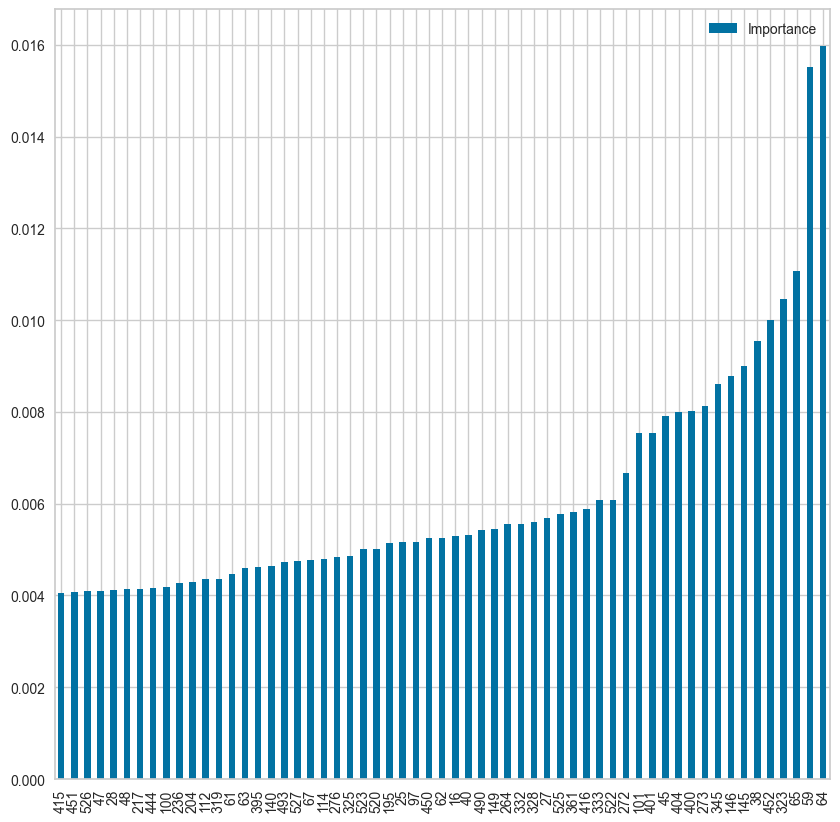

In [62]:
importance_df_filtered_1 = importance_df[importance_df['Importance']>0.004]
importance_df_filtered_1.plot.bar(figsize = (10,10))

In [63]:
importance_df_filtered_1.shape

(59, 2)

<Axes: >

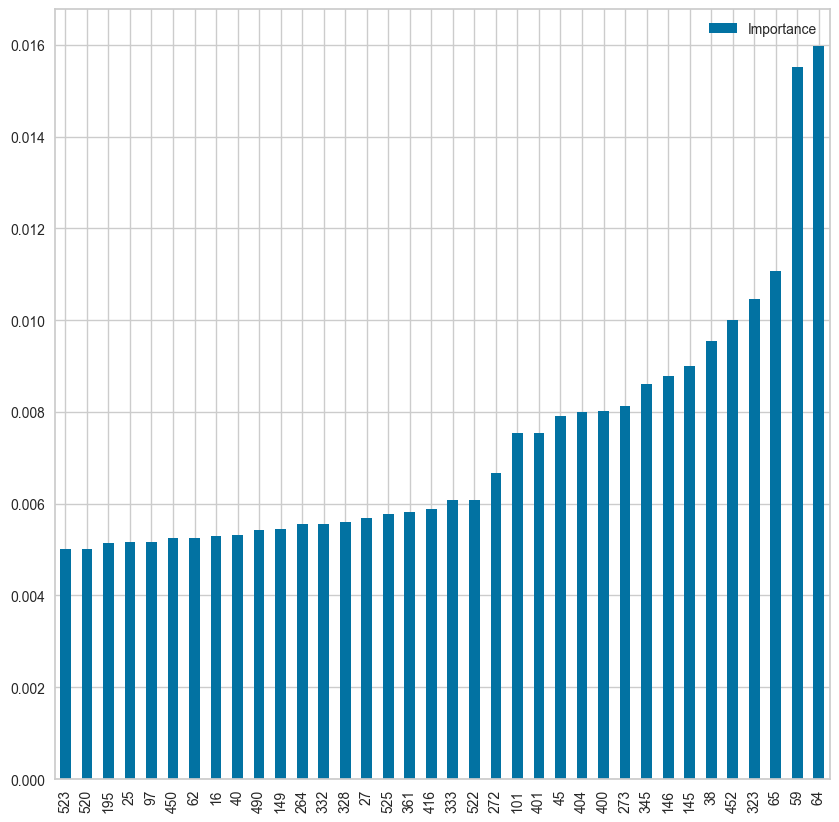

In [64]:
importance_df_filtered_2 = importance_df[importance_df['Importance']>0.005]
importance_df_filtered_2.plot.bar(figsize = (10,10))

In [65]:
importance_df_filtered_2.shape

(36, 2)

Initially the graph was hard to make out because it included all of the features but after applying a filter of > 0.04 importance we get 59 features and with > 0.05 we get 36. I am pretty sure that the RF will be our final model, but for the sake of consistency let us test out the 59 and 36 feature dataset on all try models. 

In [66]:
X_train_rf1 = X_train[(importance_df_filtered_1['Features'])]
X_test_rf1 = X_test[(importance_df_filtered_1['Features'])]
X_train_rf1.shape

(1096, 59)

In [67]:
X_train_rf2 = X_train[(importance_df_filtered_2['Features'])]
X_test_rf2 = X_test[(importance_df_filtered_2['Features'])]
X_train_rf2.shape

(1096, 36)

In [68]:
seed = 34

pipelines = []
pipelines.append(('ScaledLR', 
                  Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledRF', 
                  Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier(
                      random_state=21))])))
pipelines.append(('ScaledGBM', 
                  Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier(
                      random_state=21))])))

results = []
names = []

for name, model in pipelines:
    start_time = time.time()
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, X_train_rf1, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(name)
    runtime = time.time() - start_time
    msg = "%s: %f (%f) Run time %f sec" % (name, cv_results.mean(), cv_results.std(), runtime)
    print(msg)

ScaledLR: 0.530807 (0.050565) Run time 0.524918 sec
ScaledRF: 0.515335 (0.037951) Run time 23.621270 sec
ScaledGBM: 0.563426 (0.067340) Run time 51.424009 sec


In [69]:
seed = 34

pipelines = []
pipelines.append(('ScaledLR', 
                  Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledRF', 
                  Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier(
                      random_state=21))])))
pipelines.append(('ScaledGBM', 
                  Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier(
                      random_state=21))])))

results = []
names = []

for name, model in pipelines:
    start_time = time.time()
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, X_train_rf2, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(name)
    runtime = time.time() - start_time
    msg = "%s: %f (%f) Run time %f sec" % (name, cv_results.mean(), cv_results.std(), runtime)
    print(msg)

ScaledLR: 0.529370 (0.048984) Run time 0.489934 sec
ScaledRF: 0.522106 (0.040184) Run time 19.117107 sec
ScaledGBM: 0.565529 (0.079308) Run time 32.110467 sec


Now we get best performance both in terms of accuracy and speed when applying the 36 feature dataset. Let us look quickly at a correlation matrix to see how the features are related to each other

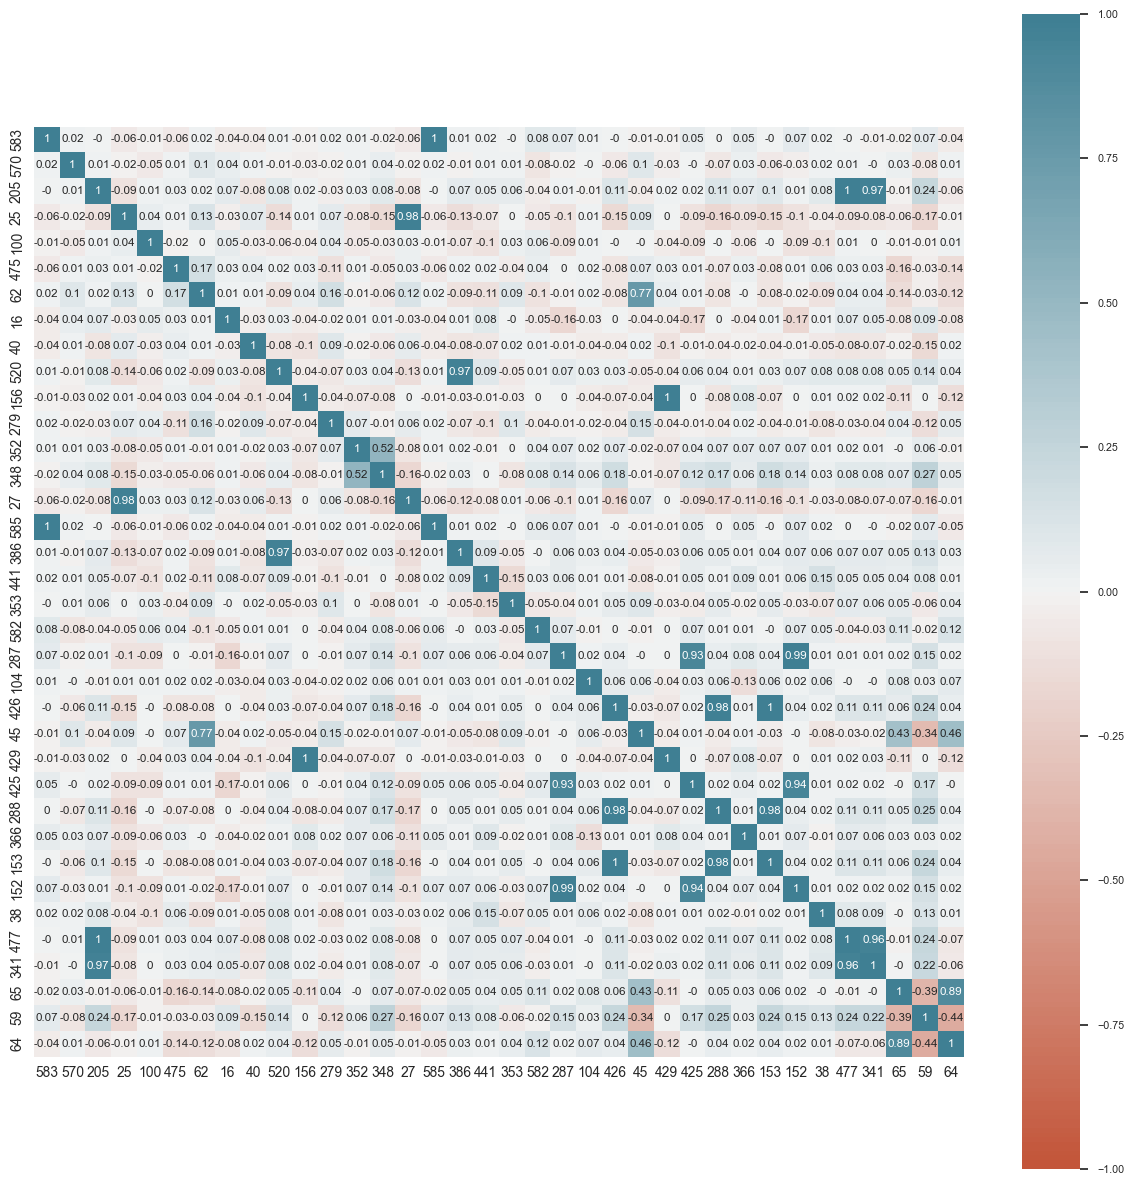

In [70]:
cormat = round(X_train_rf2.corr(),2)
fig, ax = plt.subplots(figsize=(15,15)) 

sns.set(font_scale=0.7) 
ax = sns.heatmap(
    cormat, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True
)


Now we see that we have highly correlated features, which is always bad regardless of the model type. In essence the modal will "act" like the pairwise correlated features are two times more important the features with no such correlation. Let us apply the function we used earlier for the 59 and 36 features dataset and apply the prediction once more.   

In [71]:
corr_features = correlation(X_train_rf1, 0.5)
X_train_rf1_cr = X_train_rf1.drop(corr_features, axis=1)
X_test_rf1_cr = X_test_rf1.drop(corr_features, axis=1)
n_features3 = X_train_rf1_cr.shape[1]
print(f'After removing {len(corr_features)} features, there are {n_features3} features left.')

After removing 24 features, there are 35 features left.


In [72]:
corr_features = correlation(X_train_rf2, 0.5)
X_train_rf2_cr = X_train_rf2.drop(corr_features, axis=1)
X_test_rf2_cr = X_test_rf2.drop(corr_features, axis=1)
n_features3 = X_train_rf2_cr.shape[1]
print(f'After removing {len(corr_features)} features, there are {n_features3} features left.')

After removing 13 features, there are 23 features left.


In [73]:
seed = 34

pipelines = []
pipelines.append(('ScaledLR', 
                  Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledRF', 
                  Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier(
                      random_state=21))])))
pipelines.append(('ScaledGBM', 
                  Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier(
                      random_state=21))])))

results = []
names = []

for name, model in pipelines:
    start_time = time.time()
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, X_train_rf1_cr, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(name)
    runtime = time.time() - start_time
    msg = "%s: %f (%f) Run time %f sec" % (name, cv_results.mean(), cv_results.std(), runtime)
    print(msg)

ScaledLR: 0.548633 (0.078577) Run time 0.233945 sec
ScaledRF: 0.522500 (0.045346) Run time 15.340063 sec
ScaledGBM: 0.551389 (0.067727) Run time 30.516642 sec


In [122]:
seed = 34

pipelines = []
pipelines.append(('ScaledLR', 
                  Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledRF', 
                  Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier(
                      random_state=21))])))
pipelines.append(('ScaledGBM', 
                  Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier(
                      random_state=21))])))

results = []
names = []

for name, model in pipelines:
    start_time = time.time()
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, X_train_rf2_cr, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(name)
    runtime = time.time() - start_time
    msg = "%s: %f (%f) Run time %f sec" % (name, cv_results.mean(), cv_results.std(), runtime)
    print(msg)

ScaledLR: 0.528939 (0.048451) Run time 0.176487 sec
ScaledRF: 0.547843 (0.047205) Run time 13.123558 sec
ScaledGBM: 0.573841 (0.081154) Run time 19.960549 sec
ScaledHGBM: 0.501718 (0.012010) Run time 7.492068 sec


##### GBM fine tuning
Let us try to improve the GBM with the final features selected from the `RandomForestClassier` via hyperparameter tuning 

In [100]:
def model_tunning(model,x, y, hyperparameter, values):
    '''Check the best hyperparameter from a list of values for a specific model'''
    seed = 34

    scaler = StandardScaler().fit(x)
    rescaledX = scaler.transform(x)
    param_grid = dict(z=np.array(values))
    param_grid[hyperparameter] = param_grid['z']
    del param_grid['z']
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='balanced_accuracy', cv=kfold)
    grid_result = grid.fit(rescaledX, y)

    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [101]:
model_tunning(GradientBoostingClassifier(random_state=21), 
              X_train_rf2_cr, y_train, 'n_estimators', [50, 100, 150, 200, 350])

0.562512 (0.077723) with: {'n_estimators': 50}
0.573841 (0.081154) with: {'n_estimators': 100}
0.580067 (0.078653) with: {'n_estimators': 150}
0.575900 (0.079739) with: {'n_estimators': 200}
0.585187 (0.077885) with: {'n_estimators': 350}
Best: 0.585187 using {'n_estimators': 350}


In [102]:
model_tunning(GradientBoostingClassifier(random_state=21), 
              X_train_rf2_cr, y_train, 'n_estimators', [350, 400, 500])

0.585187 (0.077885) with: {'n_estimators': 350}
0.588543 (0.074172) with: {'n_estimators': 400}
0.592889 (0.071548) with: {'n_estimators': 500}
Best: 0.592889 using {'n_estimators': 500}


In [103]:
model_tunning(GradientBoostingClassifier(random_state=21), 
              X_train_rf2_cr, y_train, 'n_estimators', [500, 550, 600])

0.592889 (0.071548) with: {'n_estimators': 500}
0.588514 (0.074672) with: {'n_estimators': 550}
0.588038 (0.073710) with: {'n_estimators': 600}
Best: 0.592889 using {'n_estimators': 500}


In [104]:
model_tunning(GradientBoostingClassifier(random_state=21, n_estimators=500), 
              X_train_rf2_cr, y_train, 'learning_rate', [0.05,0.075,0.1,0.25,0.5])

0.581858 (0.075670) with: {'learning_rate': 0.05}
0.587087 (0.077691) with: {'learning_rate': 0.075}
0.592889 (0.071548) with: {'learning_rate': 0.1}
0.575754 (0.075217) with: {'learning_rate': 0.25}
0.578518 (0.079222) with: {'learning_rate': 0.5}
Best: 0.592889 using {'learning_rate': 0.1}


In [106]:
model_tunning(GradientBoostingClassifier(random_state=21, n_estimators=500, 
                                         learning_rate=0.1), 
              X_train_rf2_cr, y_train, 'max_depth', [1,2,3,4,5])

0.594511 (0.072284) with: {'max_depth': 1}
0.584325 (0.077663) with: {'max_depth': 2}
0.592889 (0.071548) with: {'max_depth': 3}
0.579674 (0.082473) with: {'max_depth': 4}
0.577552 (0.072178) with: {'max_depth': 5}
Best: 0.594511 using {'max_depth': 1}


Our final model uses 500 `estimators` with a `learning_rate` of 0.1 and a `max_debt` of 1, so technically we are doing bagging. 

In [108]:
X_train_rf2_cr.columns

Index(['583', '570', '205', '25', '100', '475', '62', '16', '40', '520', '156',
       '279', '352', '441', '353', '582', '287', '104', '426', '366', '38',
       '65', '59'],
      dtype='object')

### Model validation

Of all we have tried we get very similar F1-scores. Following the approach of KISS (keep it simple stupid), we may exclude the approach of using dimension reduction techniques (that is the PCA or SVD), because as mentioned they are a. generally hard to explain to stakeholders and b. make it hard to know which raw features work best. The LASSO approach keep 175 features, which is pretty high compared to the manual or the RF selection so we won't be using LASSO either.     

Now let us use the test dataset to evaluate the models (so far we have only applied cross-validation). Since the F1-scores we high in all the cases I won't be doing any hyperparameter tuning here, rather just compare the `LogisticRegression` with manually selected features using the 3 functions verses the `RandomForestClassifier` with 19 features. I will include more metrics then just the F1-score. 

##### Logistic Regression validation

We already apply the 3 functions to the test dataset so we can directly predict on the `X_test_corw` dataset


In [85]:
def evaluate(train_df, test_df, train_target, test_target, estimator):
    
    # first, we should scale our data so logistic regression works better
    
    # training the model
    start_time = time.time()
    estimator.fit(train_df, train_target)
    runtime = time.time() - start_time
    
    # evaluation and scoring
    y_pred = estimator.predict(test_df)
    y_true = test_target
    f1score = f1_score(y_true, y_pred, average='micro')
    mccscore=matthews_corrcoef(y_true, y_pred)
    
    # visualizations
    cre = ClassPredictionError(estimator, classes=['fail', 'pass'])
    cre.score(test_df, y_true)
    cre.show()
    cm = ConfusionMatrix(estimator, classes=['fail', 'pass'])
    cm.score(test_df, y_true)
    cm.show()
    rocauc = RocCurveDisplay.from_estimator(estimator, test_df, y_true)
    plt.show()
    
    return f'Run time: {runtime}, F1-score: {f1score}, MCC: {mccscore}' 

C:\Users\ddash\AppData\Roaming\Python\Python311\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


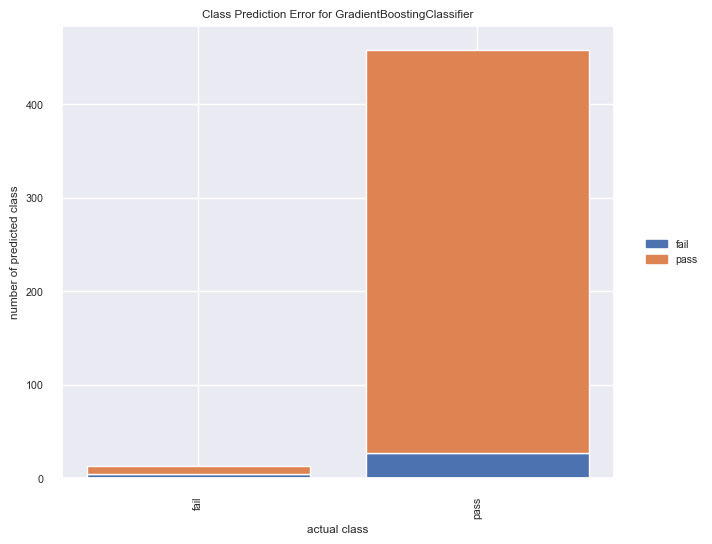

C:\Users\ddash\AppData\Roaming\Python\Python311\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


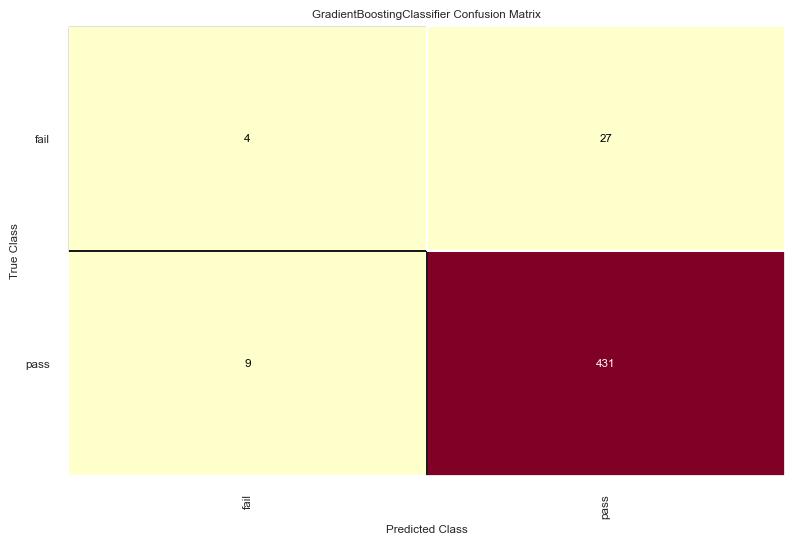

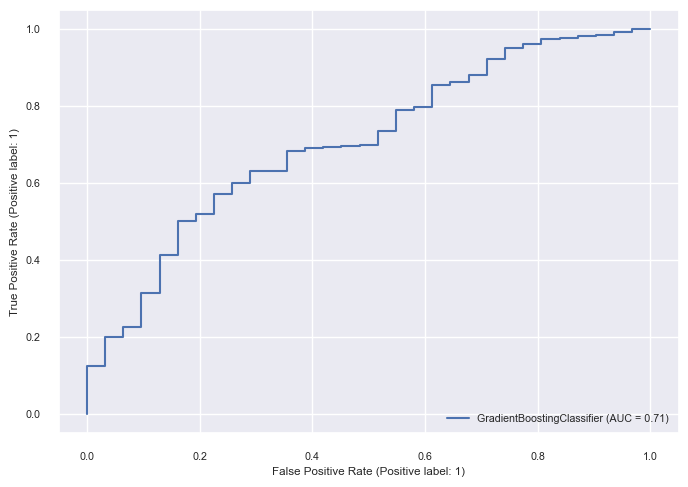

'Run time: 3.750174045562744, F1-score: 0.9235668789808917, MCC: 0.1643400664361522'

In [107]:
evaluate(X_train_rf2_cr, X_test_rf2_cr, y_train, y_test, GradientBoostingClassifier(random_state=21, n_estimators=500, 
                                         learning_rate=0.1, max_depth=1))

In [97]:
pca_fit = PCA(n_components=168)
X_test_pca_095 = pca_fit.fit_transform(X_test_scaled)

C:\Users\ddash\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ddash\AppData\Roaming\Python\Python311\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


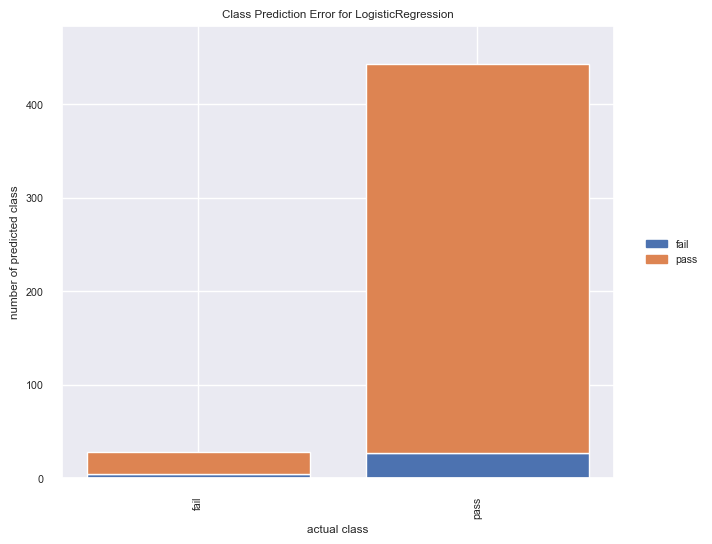

C:\Users\ddash\AppData\Roaming\Python\Python311\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


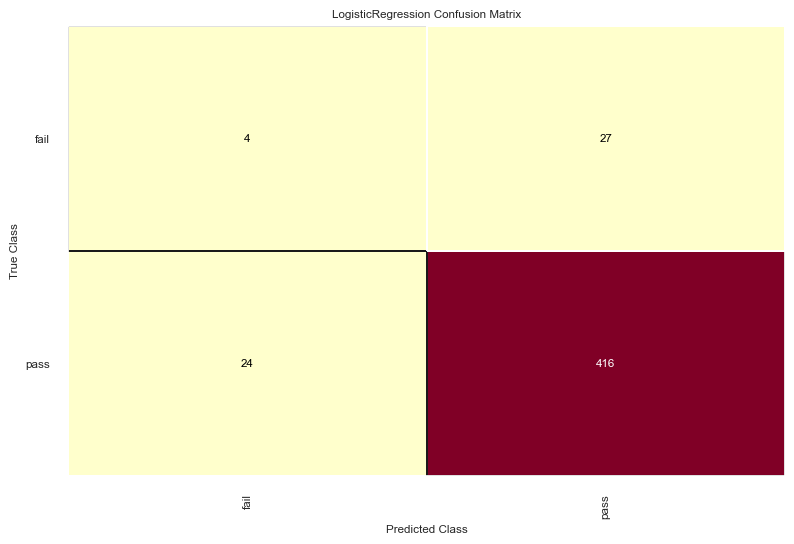

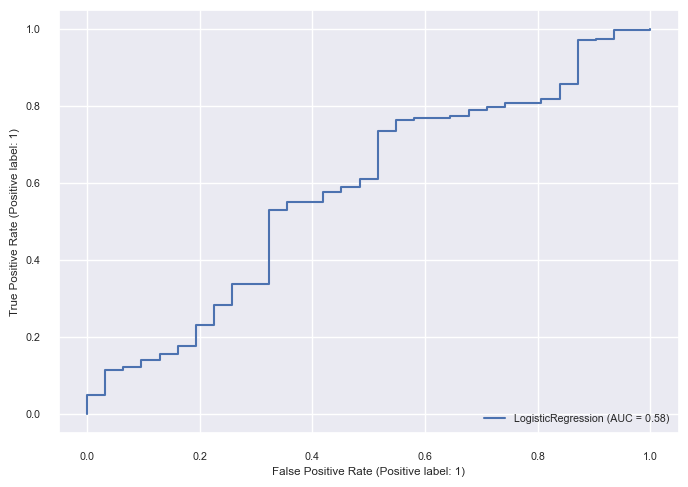

'Run time: 0.07441306114196777, F1-score: 0.89171974522293, MCC: 0.07810982126026837'

In [98]:
evaluate(X_train_pca_095, X_test_pca_095, y_train, y_test, LogisticRegression())

In [111]:
model = GradientBoostingClassifier(random_state=21, n_estimators=500, 
                                         learning_rate=0.1, max_depth=1)
model.fit(X_train_rf2_cr, y_train)

GradientBoostingClassifier(max_depth=1, n_estimators=500, random_state=21)

In [110]:
model_pkl_file = "uci_semiconductor_model.pkl"  

In [112]:
with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)

In [ ]:
with open(self.model_name, 'rb') as file:  
    model = pickle.load(file)